In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
%ls

leaf-classification/


## **EDA**

## **Import Dataset**

In [16]:
import numpy as np
import pandas as pd

import cv2
import hashlib
import matplotlib.pyplot as plt

import PIL
from PIL import Image
from PIL import ImageStat

from tqdm.notebook import tqdm

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

In [17]:
import albumentations
albumentations.__version__

'0.1.12'

In [18]:
CFG = {
    'rootdir':'../d2l/leaf-classification/'
}

In [19]:
train = pd.read_csv(CFG['rootdir'] + 'train.csv')
test = pd.read_csv(CFG['rootdir'] + 'test.csv')
submission_sample = pd.read_csv(CFG['rootdir'] + 'sample_submission.csv')

In [20]:
train.sample(10)

image                     label
13303  images/13303.jpg         prunus_virginiana
8678    images/8678.jpg          pinus_thunbergii
14419  images/14419.jpg         cercis_canadensis
16837  images/16837.jpg  broussonettia_papyrifera
6869    images/6869.jpg            pinus_flexilis
11060  images/11060.jpg           juglans_cinerea
3166    images/3166.jpg      diospyros_virginiana
18159  images/18159.jpg   koelreuteria_paniculata
6048    images/6048.jpg             tilia_cordata
3922    images/3922.jpg       platanus_acerifolia

In [21]:
test.sample(10)

image
5959  images/24312.jpg
4171  images/22524.jpg
686   images/19039.jpg
2168  images/20521.jpg
1969  images/20322.jpg
6866  images/25219.jpg
1902  images/20255.jpg
5589  images/23942.jpg
7509  images/25862.jpg
3190  images/21543.jpg

In [22]:
print(train.shape)
print(test.shape)

(18353, 2)
(8800, 1)


In [23]:
train.label.value_counts()

maclura_pomifera            353
ulmus_rubra                 235
prunus_virginiana           223
acer_rubrum                 217
broussonettia_papyrifera    214
                           ... 
cedrus_deodara               58
ailanthus_altissima          58
crataegus_crus-galli         54
evodia_daniellii             53
juniperus_virginiana         51
Name: label, Length: 176, dtype: int64

In [24]:
submission_sample.head()

image                   label
0  images/18353.jpg      halesia_tetraptera
1  images/18354.jpg   robinia_pseudo-acacia
2  images/18355.jpg  chionanthus_virginicus
3  images/18356.jpg         ulmus_americana
4  images/18357.jpg           picea_pungens

Let's display a single image


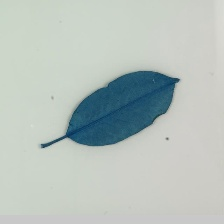

In [26]:
fig = px.imshow(cv2.imread(CFG['rootdir'] + '{}'.format(train.sample(1)['image'].values[0])))
fig.show()

## Image Meta Data

In [30]:
def get_hash(image):
  md5 = hashlib.md5()
  md5.update(np.array(image).tobytes())
  return md5.hexdigest()

def get_image_meta(image_id, image_src, dataset = 'train'):
  img = Image.open(image_src)
  extrema = img.getextrema()
  stat = ImageStat.Stat(img)

  meta = {
        'image': image_id,
        'dataset': dataset,
        'hash': get_hash(img),
        'R_min': extrema[0][0],
        'R_max': extrema[0][1],
        'G_min': extrema[1][0],
        'G_max': extrema[1][1],
        'B_min': extrema[2][0],
        'B_max': extrema[2][1],
        'R_avg': stat.mean[0],
        'G_avg': stat.mean[1],
        'B_avg': stat.mean[2],
        'height': img.height,
        'width': img.width,
        'format': img.format,
        'mode': img.mode
    }
  return meta

In [31]:
def image_metadata(df, rootdir, mark='train'):
    img_data = []
    for i, image_id in enumerate(tqdm(df['image'], total=df.shape[0])):
        img_data.append(get_image_meta(image_id, (CFG['rootdir'] + '{}'.format(image_id)), mark))
    
    meta_pd = pd.DataFrame(img_data)
    return meta_pd

In [33]:
meta_train = image_metadata(df=train, rootdir = CFG['rootdir'], mark='train')
meta_train.head()

  0%|          | 0/18353 [00:00<?, ?it/s]

image dataset                              hash  R_min  R_max  \
0  images/0.jpg   train  a3e451f614ef9d30f8ce40c5d3ab26e9     11    255   
1  images/1.jpg   train  d8a7f4f3d77ede21fdf08057f2cc2a76     29    212   
2  images/2.jpg   train  2fab616c550dffbd7c77cc83db527f55     53    255   
3  images/3.jpg   train  bf7965f72a8ea292298ef0f8d38e1d94     56    255   
4  images/4.jpg   train  c8cd255ec32df9475bf262d176247b1c     29    205   

   G_min  G_max  B_min  B_max       R_avg       G_avg       B_avg  height  \
0     12    255     10    255  242.714146  243.177794  242.640246     224   
1     34    217     26    213  188.788006  195.295480  188.551459     224   
2     55    255     53    255  235.176160  235.877730  234.513293     224   
3     56    255     56    255  231.735830  232.241908  231.272999     224   
4     32    212     30    207  188.485850  197.165996  189.786910     224   

   width format mode  
0    224   JPEG  RGB  
1    224   JPEG  RGB  
2    224   JPEG  RGB  
3    224   JPEG  RGB  
4    224   JPEG  RGB

In [34]:
meta_test = image_metadata(test, rootdir = CFG['rootdir'], mark='test')
meta_test.head()

  0%|          | 0/8800 [00:00<?, ?it/s]

image dataset                              hash  R_min  R_max  \
0  images/18353.jpg    test  0791515dfa647ef28404409a5e19248a      9    185   
1  images/18354.jpg    test  b67ca37e9496ef024be0f4ca979f0754      8    195   
2  images/18355.jpg    test  b95c7910bc565abe7fed2655d78b2044      2    255   
3  images/18356.jpg    test  8f9df1975fcf3365a8818dc5100a0750     28    215   
4  images/18357.jpg    test  c4b93f84fba230e47da6e0b828dfc809     10    250   

   G_min  G_max  B_min  B_max       R_avg       G_avg       B_avg  height  \
0     18    190      0    186  129.379504  133.808494  126.382972     224   
1     13    189      0    191  134.952507  138.653021  131.411651     224   
2      3    255      0    255  226.100566  227.091538  223.575275     224   
3     40    222     28    221  197.032087  208.234076  202.516163     224   
4     20    245      0    241  130.410535  133.729253  120.305584     224   

   width format mode  
0    224   JPEG  RGB  
1    224   JPEG  RGB  
2    224   JPEG  RGB  
3    224   JPEG  RGB  
4    224   JPEG  RGB

## Visualize The Data

In [35]:
fig = px.histogram(train, 'label', marginal='violin', hover_data = train.columns)
fig.update_layout(title_text = 'Distribution of Classes')
fig.show()

In [37]:
fig = ff.create_distplot([meta_train['R_avg']], group_labels = ['ChannelsR'], colors = ['RED'])
fig.update_layout(showlegend = False, template = 'simple_white')
fig.update_layout(title_text = 'Distribution of Channel Values')
fig.data[0].marker.line.color = 'rgb(0,0,0)'
fig.data[0].marker.line.width = 0.5
fig

In [38]:
fig = ff.create_distplot([meta_train['R_avg'], meta_train['G_avg'], meta_train['B_avg']], group_labels=['R','G','B'], colors=["RED",'GREEN','BLUE'])
fig.update_layout(showlegend=False, template="simple_white")
fig.update_layout(title_text="Distribution of Channel Values")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig.data[1].marker.line.color = 'rgb(0, 0, 0)'
fig.data[1].marker.line.width = 0.5
fig.data[2].marker.line.color = 'rgb(0, 0, 0)'
fig.data[2].marker.line.width = 0.5
fig

In [39]:
fig = go.Figure()

for idx, values in enumerate([meta_train['R_avg'], meta_train['G_avg'], meta_train['B_avg']]):
  if idx == 0:
    color = 'RED'
  if idx == 1:
    color = 'GREEN'
  if idx == 2:
    color = 'BLUE'
  fig.add_trace(go.Box(x=[color]*len(values), y=values, name=color, marker=dict(color = color.lower())))

fig.update_layout(yaxis_title='Mean Value', xaxis_title='Color Channel',
                  title = 'Mean Value vs. Color Channel', template ='plotly_white')

We can see that RGB channel plot are mostly over lapped, since there are a lot of white space in out image data. The white channel [255,255,255] raised a lot of our average level. A boundbox might can help us reduce those useless pixels.(TBD)

## Noisy in Data

In [42]:
def get_duplicate(dt, mark = 'train'):
  dup = dt.groupby(by = 'hash')[['dataset']].count().reset_index()
  dup = dup[dup['dataset'] > 1]
  dup.reset_index(drop = True ,inplace = True)
  dup = dup.merge(dt[['image','hash']], on='hash')
  dup['dup_number'] = dup['dataset']
  dup.loc[:,'dataset'] = mark

  return dup

In [43]:
dup_train = get_duplicate(meta_train, 'train')
dup_train

hash dataset             image  dup_number
0    004ebc4c323e94d7fd5a88e00c4686dc   train   images/4200.jpg           2
1    004ebc4c323e94d7fd5a88e00c4686dc   train   images/8740.jpg           2
2    01e5f911777069d334c8af88cc28860c   train  images/11368.jpg           2
3    01e5f911777069d334c8af88cc28860c   train  images/11750.jpg           2
4    055a9310e58bf1305fac8c00fa5060d2   train   images/1274.jpg           2
..                                ...     ...               ...         ...
724  fde2210239d1504b3876f3d5d39141b4   train  images/16746.jpg           2
725  fec9a6addbe2ff34503b21371fe3ff5e   train  images/11987.jpg           2
726  fec9a6addbe2ff34503b21371fe3ff5e   train  images/13734.jpg           2
727  ffd2c8aeace5466200421028ab12e5bd   train    images/481.jpg           2
728  ffd2c8aeace5466200421028ab12e5bd   train   images/3303.jpg           2

[729 rows x 4 columns]

In [44]:
dup_test = get_duplicate(meta_test, 'test')
dup_test

hash dataset             image  dup_number
0   0b0641bac67b9e7e078c75956ad0f1c6    test  images/22349.jpg           2
1   0b0641bac67b9e7e078c75956ad0f1c6    test  images/26285.jpg           2
2   0bbc13fceea7e1bc75cc66125978ecae    test  images/23437.jpg           2
3   0bbc13fceea7e1bc75cc66125978ecae    test  images/25051.jpg           2
4   13f02dfca9a48781f13726aca0f52329    test  images/19337.jpg           2
..                               ...     ...               ...         ...
67  f431271ed2abc8fd4818b1576f3702c8    test  images/24078.jpg           2
68  f4e913f0ea819969ab3831797ca578c8    test  images/18836.jpg           2
69  f4e913f0ea819969ab3831797ca578c8    test  images/19155.jpg           2
70  f7550d07fb656f400476b49715ea0392    test  images/23069.jpg           2
71  f7550d07fb656f400476b49715ea0392    test  images/23383.jpg           2

[72 rows x 4 columns]

In [45]:
dup_test['dup_number'].value_counts()

2    62
3     6
4     4
Name: dup_number, dtype: int64

In [46]:
dup_train = dup_train.merge(train[['image', 'label']], on='image')
dup_train

hash dataset             image  dup_number  \
0    004ebc4c323e94d7fd5a88e00c4686dc   train   images/4200.jpg           2   
1    004ebc4c323e94d7fd5a88e00c4686dc   train   images/8740.jpg           2   
2    01e5f911777069d334c8af88cc28860c   train  images/11368.jpg           2   
3    01e5f911777069d334c8af88cc28860c   train  images/11750.jpg           2   
4    055a9310e58bf1305fac8c00fa5060d2   train   images/1274.jpg           2   
..                                ...     ...               ...         ...   
724  fde2210239d1504b3876f3d5d39141b4   train  images/16746.jpg           2   
725  fec9a6addbe2ff34503b21371fe3ff5e   train  images/11987.jpg           2   
726  fec9a6addbe2ff34503b21371fe3ff5e   train  images/13734.jpg           2   
727  ffd2c8aeace5466200421028ab12e5bd   train    images/481.jpg           2   
728  ffd2c8aeace5466200421028ab12e5bd   train   images/3303.jpg           2   

                     label  
0        prunus_virginiana  
1       prunus_subhirtella  
2         prunus_sargentii  
3    quercus_muehlenbergii  
4         maclura_pomifera  
..                     ...  
724           ulmus_pumila  
725   cryptomeria_japonica  
726   cryptomeria_japonica  
727   cryptomeria_japonica  
728   cryptomeria_japonica  

[729 rows x 5 columns]

In [47]:
tester = dup_train.copy()
tester = tester.drop_duplicates(subset = ['hash','label'], keep = False)

In [48]:
tester['dup_number'].value_counts()

2    112
3     39
Name: dup_number, dtype: int64

In [49]:
tester.head(10)

hash dataset             image  dup_number  \
0   004ebc4c323e94d7fd5a88e00c4686dc   train   images/4200.jpg           2   
1   004ebc4c323e94d7fd5a88e00c4686dc   train   images/8740.jpg           2   
2   01e5f911777069d334c8af88cc28860c   train  images/11368.jpg           2   
3   01e5f911777069d334c8af88cc28860c   train  images/11750.jpg           2   
14  0ebfcf142008592147cc990f0ce2bc73   train  images/12740.jpg           2   
15  0ebfcf142008592147cc990f0ce2bc73   train  images/17561.jpg           2   
16  10d5d7b0bc4b97e24a31acbc7f96de7a   train  images/10758.jpg           2   
17  10d5d7b0bc4b97e24a31acbc7f96de7a   train  images/17521.jpg           2   
26  13ebf04d03a0089b06da7720f24c0258   train     images/50.jpg           2   
27  13ebf04d03a0089b06da7720f24c0258   train   images/3967.jpg           2   

                    label  
0       prunus_virginiana  
1      prunus_subhirtella  
2        prunus_sargentii  
3   quercus_muehlenbergii  
14      magnolia_stellata  
15     magnolia_tripetala  
16     magnolia_tripetala  
17      magnolia_stellata  
26      prunus_virginiana  
27     prunus_subhirtella

In [50]:
def plot_dup(df, number):
    fig, ax = plt.subplots(int(number/2), 2, figsize=(10, 30))
    ax = ax.flatten()

    for i in range(0, min(tester.shape[0], number), 2):
        image_i = cv2.imread(CFG['rootdir'] + '{}'.format(df.iloc[i, 2]), cv2.IMREAD_COLOR)
        image_i = cv2.cvtColor(image_i, cv2.COLOR_BGR2RGB)
        ax[i].set_axis_off()
        ax[i].imshow(image_i)
        ax[i].set_title(df.iloc[i, 2] + '\n' + df.iloc[i, 4])

        image_i_1 = cv2.imread(CFG['rootdir'] + '{}'.format(df.iloc[i + 1, 2]), cv2.IMREAD_COLOR)
        image_i_1 = cv2.cvtColor(image_i_1, cv2.COLOR_BGR2RGB)
        ax[i + 1].set_axis_off()
        ax[i + 1].imshow(image_i_1)
        ax[i + 1].set_title(df.iloc[i + 1, 2] + '\n' + df.iloc[i + 1,4])

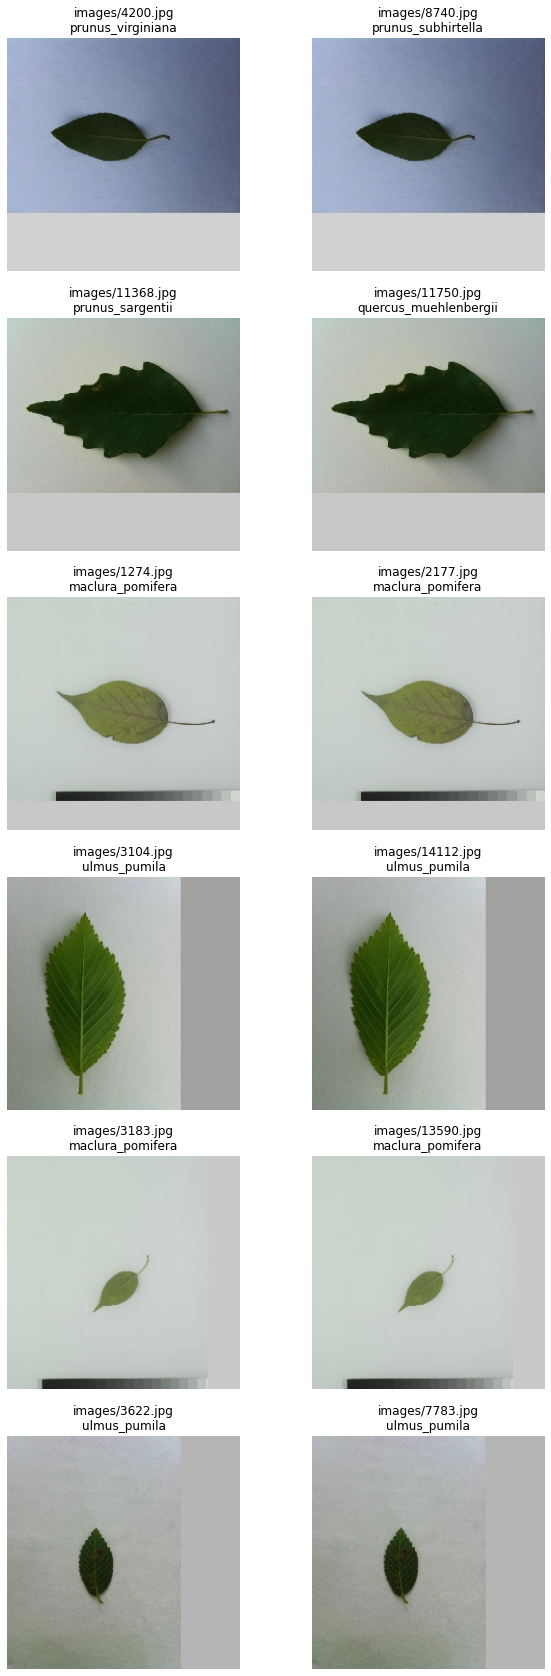

In [51]:
plot_dup(dup_train, 12)

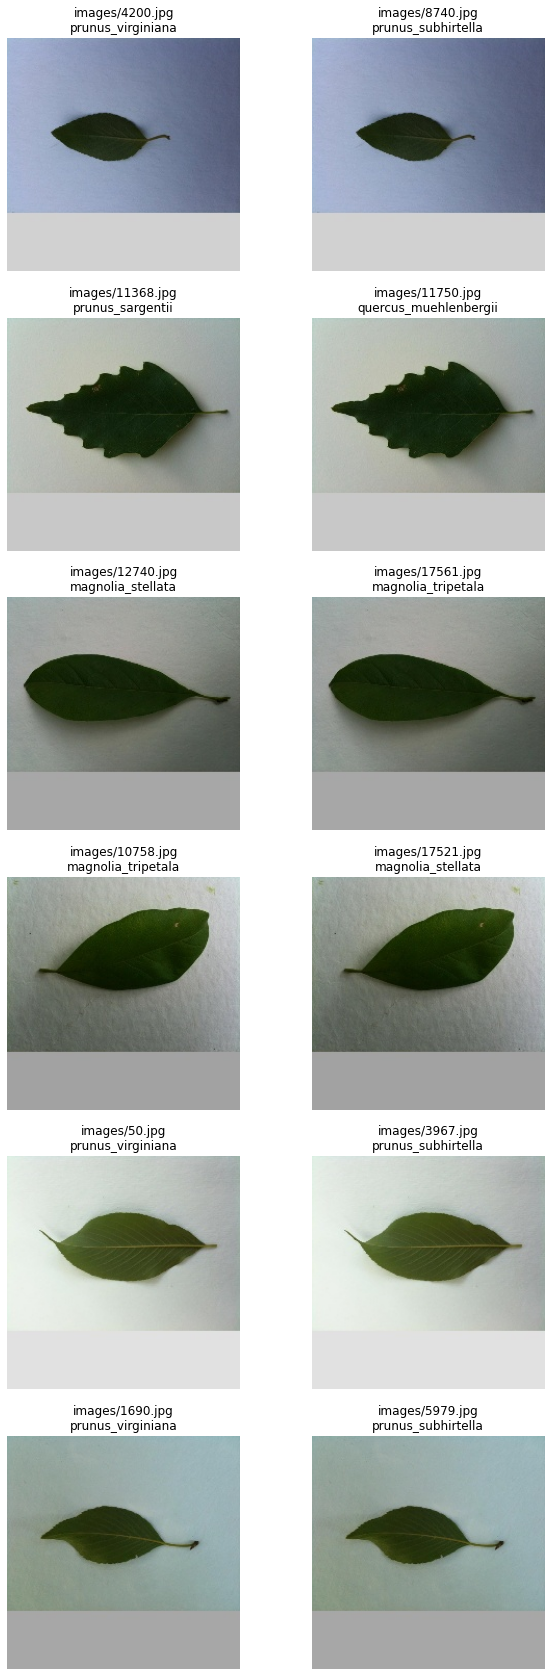

In [52]:
plot_dup(tester, 12)

In [53]:
train_clean = train[~train['image'].isin(tester['image'])].reset_index(drop = True)

In [55]:
train_clean.nunique()

image    18202
label      176
dtype: int64

In [56]:
# save cleaned data
train_clean.to_csv('train_clean.csv', index = False)

## Canny edge detection

In [57]:
def edge_and_cut(img_src):
    img = cv2.imread(img_src)
    emb_img = img.copy()
    edges = cv2.Canny(img, 100, 200)
    edge_coors = []
    for i in range(edges.shape[0]):
        for j in range(edges.shape[1]):
            if edges[i][j] != 0:
                edge_coors.append((i, j))
    
    row_min = edge_coors[np.argsort([coor[0] for coor in edge_coors])[0]][0]
    row_max = edge_coors[np.argsort([coor[0] for coor in edge_coors])[-1]][0]
    col_min = edge_coors[np.argsort([coor[1] for coor in edge_coors])[0]][1]
    col_max = edge_coors[np.argsort([coor[1] for coor in edge_coors])[-1]][1]
    new_img = img[row_min:row_max, col_min:col_max]
    
    emb_img[row_min-5:row_min+5, col_min:col_max] = [255, 0, 0]
    emb_img[row_max-5:row_max+5, col_min:col_max] = [255, 0, 0]
    emb_img[row_min:row_max, col_min-5:col_min+5] = [255, 0, 0]
    emb_img[row_min:row_max, col_max-5:col_max+5] = [255, 0, 0]
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30, 20))
    ax[0].imshow(img)
    ax[0].set_title('Original Image', fontsize=24)
    ax[1].imshow(edges, cmap='gray')
    ax[1].set_title('Canny Edges', fontsize=24)
    ax[2].imshow(emb_img, cmap='gray')
    ax[2].set_title('Bounding Box', fontsize=24)
    plt.show()

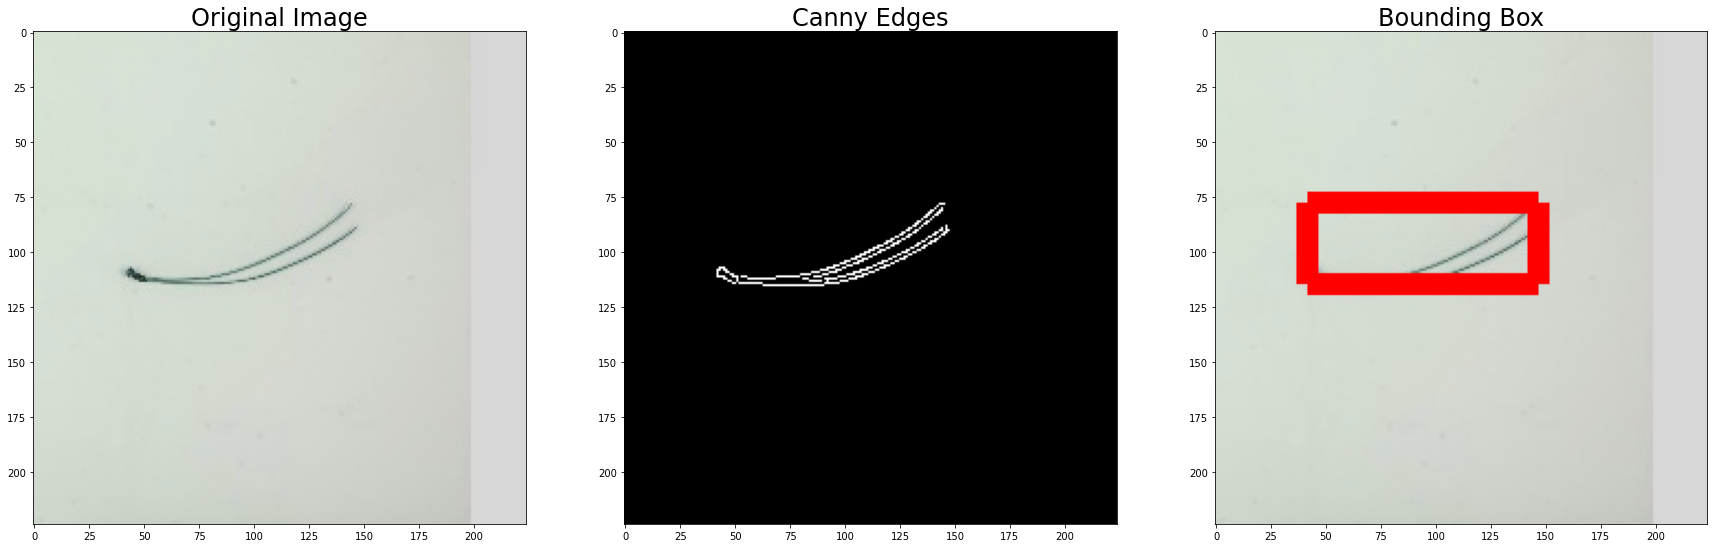

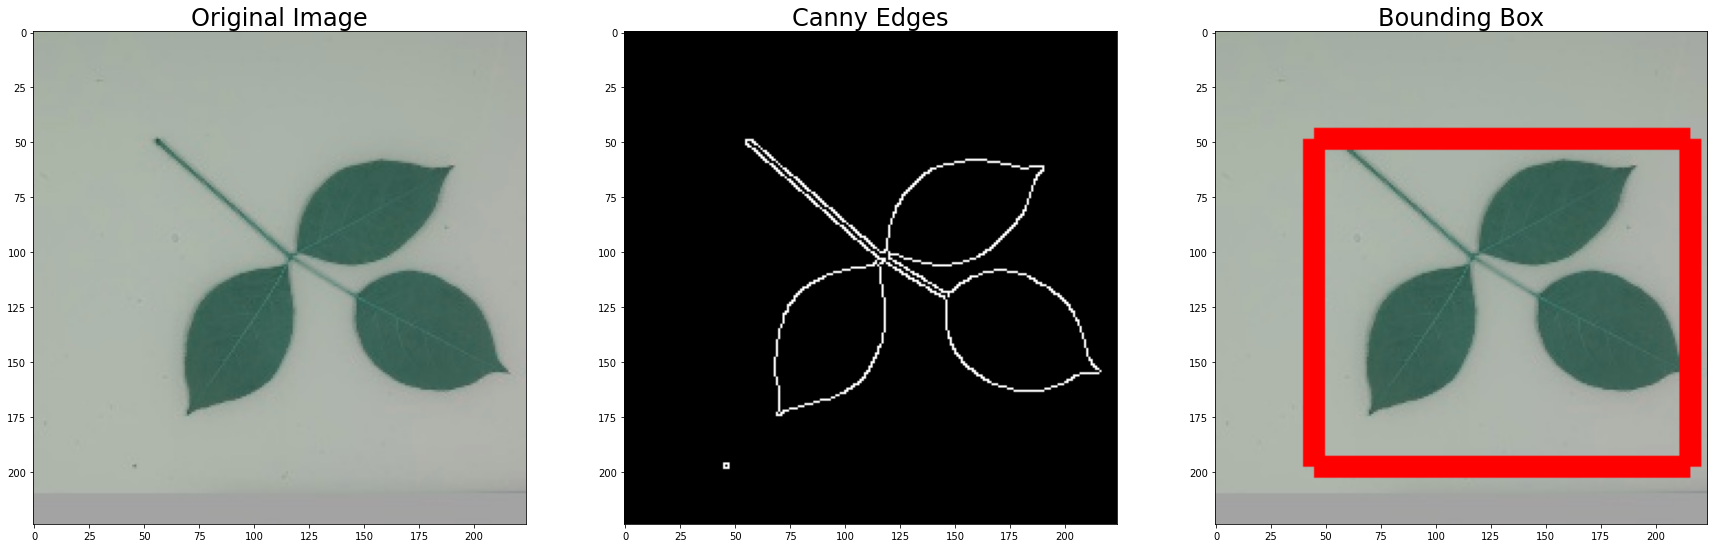

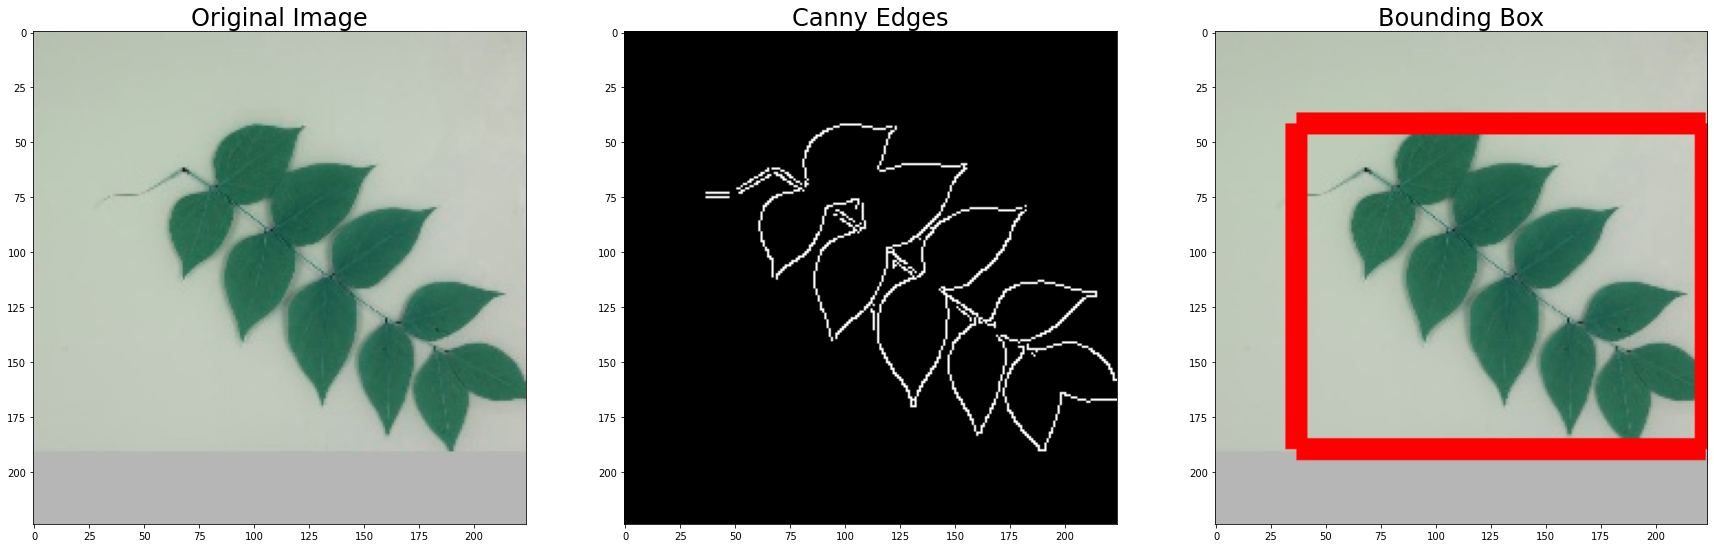

In [61]:
edge_and_cut('../d2l/leaf-classification/images/9294.jpg')
edge_and_cut('../d2l/leaf-classification/images/2333.jpg')
edge_and_cut('../d2l/leaf-classification/images/2666.jpg')

# Image Augmentation

The augmentation method can be divided as follows:  
* Geometric transformations
* Color space transformations
* Kernel filters
* Mixing images
* Random erasing

## Albumentations

In [63]:
!pip install -U albumentations
import albumentations
albumentations.__version__

     |████████████████████████████████| 102 kB 33.2 MB/s 
     |████████████████████████████████| 47.8 MB 1.3 MB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


'0.1.12'

In [71]:
from albumentations import (
    HorizontalFlip, VerticalFlip, Rotate, ShiftScaleRotate, RandomBrightnessContrast, CLAHE, 
    Transpose, Blur, OpticalDistortion, GridDistortion, HueSaturationValue, GaussNoise, MotionBlur, MedianBlur,
    Flip, OneOf, Compose, Normalize, CenterCrop, Resize
)

In [72]:
# helper function
def get_img(imgsrc):
    im_bgr = cv2.imread(imgsrc)
    im_rgb = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2RGB)
    return im_rgb

def visualize(image):
    plt.figure(figsize=(5, 5))
    plt.axis('off')
    plt.imshow(image)

In [73]:
 def plot_aug(img_src, method):
    img = get_img(img_src)
    augmented_img = method(p=1)(image=img)['image']
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
    ax[0].imshow(img)
    ax[0].set_title('Original Image', fontsize=24)
    ax[1].imshow(augmented_img)
    ax[1].set_title(method.__name__, fontsize=24)
    plt.show()

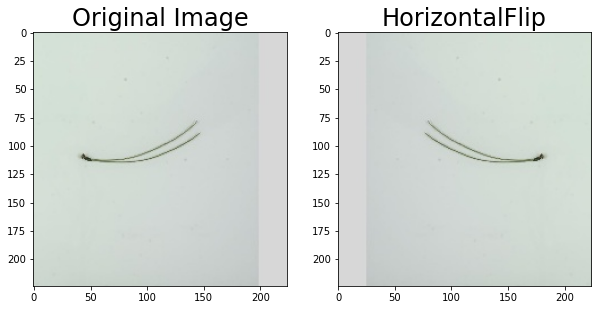

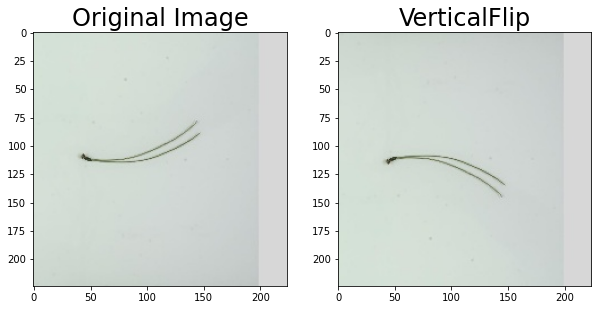

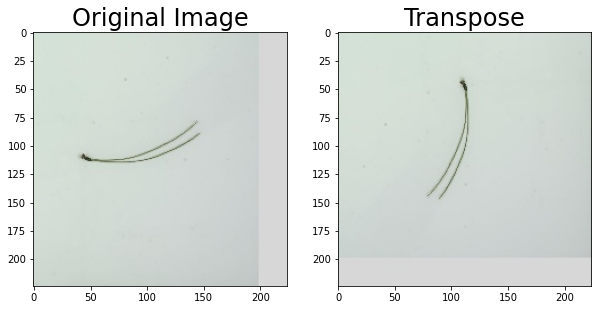

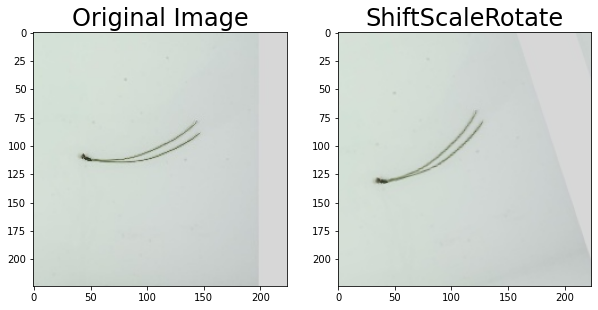

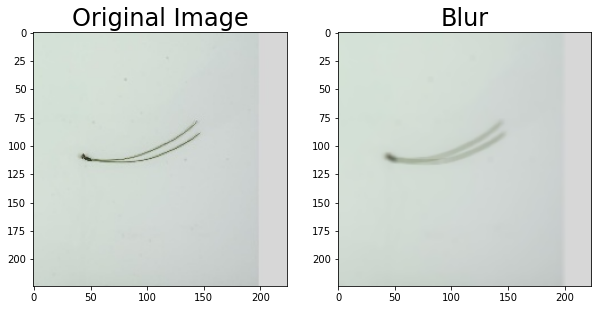

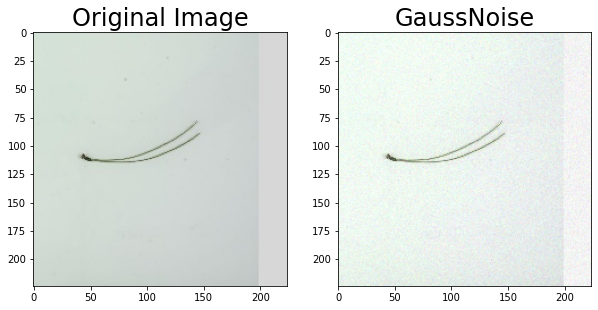

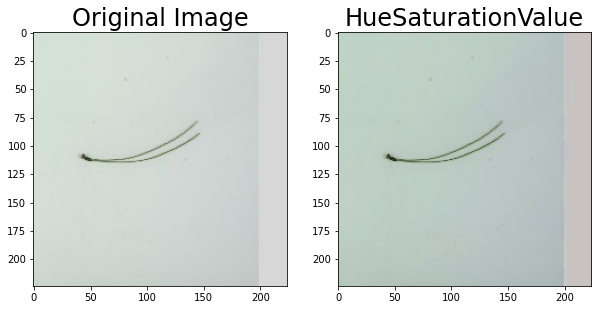

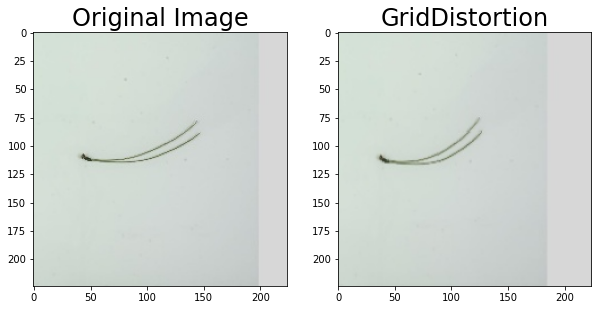

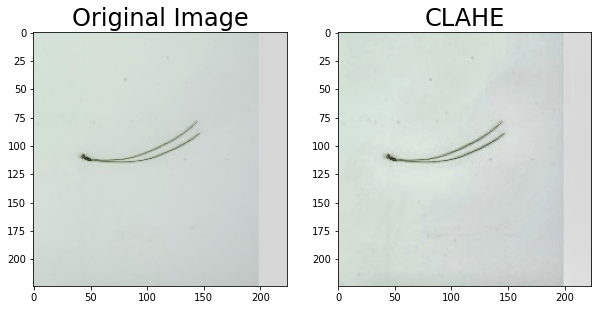

In [74]:
plot_aug('../d2l/leaf-classification/images/9294.jpg', HorizontalFlip)
plot_aug('../d2l/leaf-classification/images/9294.jpg', VerticalFlip)
plot_aug('../d2l/leaf-classification/images/9294.jpg', Transpose)
plot_aug('../d2l/leaf-classification/images/9294.jpg', ShiftScaleRotate)
plot_aug('../d2l/leaf-classification/images/9294.jpg', Blur)
plot_aug('../d2l/leaf-classification/images/9294.jpg', GaussNoise)
plot_aug('../d2l/leaf-classification/images/9294.jpg', HueSaturationValue)
plot_aug('../d2l/leaf-classification/images/9294.jpg', GridDistortion)
plot_aug('../d2l/leaf-classification/images/9294.jpg', CLAHE)

## Common Pipeline for augmentation

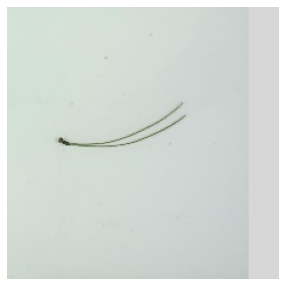

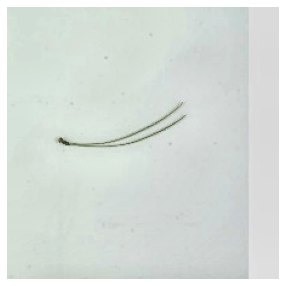

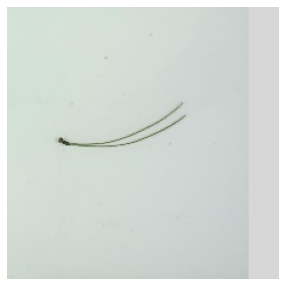

In [77]:
transform = Compose([
        OneOf([
            MotionBlur(p=.2),
            MedianBlur(blur_limit=3, p=0.1),
            Blur(blur_limit=3, p=0.1),
            GaussNoise(p=0.2),
        ], p=0.2),
        OneOf([
            CLAHE(clip_limit=2),
            GridDistortion(),
            RandomBrightnessContrast(),            
        ], p=0.3),
        OneOf([
            OpticalDistortion(),
        ], p=0.2),
        HueSaturationValue(p=0.3),
    ])

img = get_img('../d2l/leaf-classification/images/9294.jpg')

visualize(transform(image=img)['image'])
visualize(transform(image=img)['image'])
visualize(transform(image=img)['image'])


# Model
## Model Collection

In [78]:
import os
import time
from glob import glob
import random

import pandas as pd
import numpy as np

import torch
from torch import nn

from torch.utils.data import Dataset,DataLoader
from torch.cuda.amp import autocast, GradScaler

import sklearn
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.model_selection import StratifiedKFold

import cv2

from tqdm import tqdm


In [80]:
!pip install timm
!pip install torchinfo

     |████████████████████████████████| 431 kB 15.9 MB/s 


In [81]:
import timm
from torchinfo import summary

In [82]:
model_batch_size = 32

In [83]:
eff_model = timm.create_model('tf_efficientnet_b4', pretrained=True)
summary(eff_model, input_size = (model_batch_size, 3, 224, 224))

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b4_aa-818f208c.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b4_aa-818f208c.pth


Layer (type:depth-idx)                        Output Shape              Param #
EfficientNet                                  --                        --
├─Conv2dSame: 1-1                             [32, 48, 112, 112]        1,296
├─BatchNorm2d: 1-2                            [32, 48, 112, 112]        96
├─SiLU: 1-3                                   [32, 48, 112, 112]        --
├─Sequential: 1-4                             [32, 448, 7, 7]           --
│    └─Sequential: 2-1                        [32, 24, 112, 112]        --
│    │    └─DepthwiseSeparableConv: 3-1       [32, 24, 112, 112]        2,940
│    │    └─DepthwiseSeparableConv: 3-2       [32, 24, 112, 112]        1,206
│    └─Sequential: 2-2                        [32, 32, 56, 56]          --
│    │    └─InvertedResidual: 3-3             [32, 32, 56, 56]          11,878
│    │    └─InvertedResidual: 3-4             [32, 32, 56, 56]          18,120
│    │    └─InvertedResidual: 3-5             [32, 32, 56, 56]          18,120

In [84]:
eff_model_2 = timm.create_model('tf_efficientnet_b5', pretrained=True)
summary(eff_model, input_size = (model_batch_size, 3, 224, 224))

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b5_ra-9a3e5369.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b5_ra-9a3e5369.pth


Layer (type:depth-idx)                        Output Shape              Param #
EfficientNet                                  --                        --
├─Conv2dSame: 1-1                             [32, 48, 112, 112]        1,296
├─BatchNorm2d: 1-2                            [32, 48, 112, 112]        96
├─SiLU: 1-3                                   [32, 48, 112, 112]        --
├─Sequential: 1-4                             [32, 448, 7, 7]           --
│    └─Sequential: 2-1                        [32, 24, 112, 112]        --
│    │    └─DepthwiseSeparableConv: 3-1       [32, 24, 112, 112]        2,940
│    │    └─DepthwiseSeparableConv: 3-2       [32, 24, 112, 112]        1,206
│    └─Sequential: 2-2                        [32, 32, 56, 56]          --
│    │    └─InvertedResidual: 3-3             [32, 32, 56, 56]          11,878
│    │    └─InvertedResidual: 3-4             [32, 32, 56, 56]          18,120
│    │    └─InvertedResidual: 3-5             [32, 32, 56, 56]          18,120

In [85]:
res_model = timm.create_model('resnest50d', pretrained=True)
res_model.fc = nn.Linear(2048, 176)
summary(res_model, input_size = (model_batch_size, 3, 224, 224))

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-resnest/resnest50-528c19ca.pth" to /root/.cache/torch/hub/checkpoints/resnest50-528c19ca.pth


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   --                        --
├─Sequential: 1-1                        [32, 64, 112, 112]        --
│    └─Conv2d: 2-1                       [32, 32, 112, 112]        864
│    └─BatchNorm2d: 2-2                  [32, 32, 112, 112]        64
│    └─ReLU: 2-3                         [32, 32, 112, 112]        --
│    └─Conv2d: 2-4                       [32, 32, 112, 112]        9,216
│    └─BatchNorm2d: 2-5                  [32, 32, 112, 112]        64
│    └─ReLU: 2-6                         [32, 32, 112, 112]        --
│    └─Conv2d: 2-7                       [32, 64, 112, 112]        18,432
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        128
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 256, 56, 56]         --
│    └

In [86]:
del eff_model
del eff_model_2
del res_model

# Training Process

## Config

In [87]:
CFG = {
    'rootdir': '../d2l/leaf-classification/',
    'fold_num': 5,
    'seed': 123,
    'model_arch': 'tf_efficientnet_b5',
    'img_size': 224,
    'epochs': 10,
    'train_bs': 32,
    'valid_bs': 32,
    'T_0': 10, # Number of iterations for the first restart
    'lr': 3e-4,
    'min_lr': 1e-6,
    'weight_decay':1e-6,
    'num_workers': 8,
    'accum_iter': 2, # suppoprt to do batch accumulation for backprop with effectively larger batch size
    'verbose_step': 1, # 0 (silent),1 (progress bar), 2 (one line per epoch)
    'device': 'cuda:0'
}

**Helper Function**

In [88]:
# labelencoder for dataset
t_labelencoder = preprocessing.LabelEncoder()
t_labelencoder.fit(train['label'])

LabelEncoder()

In [89]:
train_clean['label'] = t_labelencoder.transform(train_clean['label'])

In [90]:
train_clean


image  label
0          images/0.jpg     78
1          images/1.jpg     78
2          images/2.jpg     78
3          images/3.jpg     78
4          images/4.jpg     78
...                 ...    ...
18197  images/18348.jpg     14
18198  images/18349.jpg     76
18199  images/18350.jpg     40
18200  images/18351.jpg    125
18201  images/18352.jpg    144

[18202 rows x 2 columns]

In [91]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
def get_img(path):
    im_bgr = cv2.imread(path)
    im_rgb = im_bgr[:, :, ::-1]
    #print(im_rgb)
    return im_rgb

## Prepare Data

In [92]:
class MyDataset(Dataset):
    def __init__(self, df, data_root, transforms=None, output_label=True):
        
        super().__init__()
        self.df = df.reset_index(drop=True).copy()
        self.transforms = transforms
        self.data_root = data_root
        
        self.output_label = output_label
        
        if output_label == True:
            self.labels = self.df['label'].values
            
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index: int):
        # get labels
        if self.output_label:
            target = self.labels[index]
          
        img  = get_img("{}/{}".format(self.data_root, self.df.loc[index]['image']))

        if self.transforms:
            img = self.transforms(image=img)['image']
        
        if self.output_label == True:
            return img, target
        else:
            return img

In [98]:
from albumentations import (
    HorizontalFlip, VerticalFlip, Rotate, ShiftScaleRotate, RandomBrightnessContrast, CLAHE, 
    Transpose, Blur, OpticalDistortion, GridDistortion, HueSaturationValue, GaussNoise, MotionBlur, MedianBlur,
    Flip, OneOf, Compose, Normalize, CenterCrop, Resize
)

from albumentations.pytorch import ToTensorV2

def get_train_transforms():
    return Compose([
            OneOf([
            GaussNoise(),
            ], p=0.5),
            OneOf([
            Transpose(p=0.5),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            ], p=0.6),
            Resize(CFG['img_size'], CFG['img_size']),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)
  
        
def get_valid_transforms():
    return Compose([
            Resize(CFG['img_size'], CFG['img_size']),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.)

In [94]:
def prepare_dataloader(df, trn_idx, val_idx, data_root='../d2l/leaf-classification/'):

    train_ = df.loc[trn_idx,:].reset_index(drop=True)
    valid_ = df.loc[val_idx,:].reset_index(drop=True)
        
    train_ds = MyDataset(train_, data_root, transforms=get_train_transforms(), output_label=True)
    valid_ds = MyDataset(valid_, data_root, transforms=get_valid_transforms(), output_label=True)
    
    train_loader = torch.utils.data.DataLoader(
        train_ds,
        batch_size=CFG['train_bs'],
        pin_memory=True,
        drop_last=False,
        shuffle=True,        
        num_workers=CFG['num_workers'],
    )
    val_loader = torch.utils.data.DataLoader(
        valid_ds, 
        batch_size=CFG['valid_bs'],
        num_workers=CFG['num_workers'],
        shuffle=False,
        pin_memory=True,
    )
    return train_loader, val_loader

## Model

In [95]:
class EfficientModel(nn.Module):
    def __init__(self, model_arch, n_class, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_arch, pretrained=pretrained)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, n_class)

    def forward(self, x):
        x = self.model(x)
        return x
    
class ResnetModel(nn.Module):
    def __init__(self, model_arch, n_class, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_arch, pretrained=pretrained)
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, n_class)
        '''
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.3),
            #nn.Linear(n_features, hidden_size,bias=True), nn.ELU(),
            nn.Linear(n_features, n_class, bias=True)
        )
        '''
    def forward(self, x):
        x = self.model(x)
        return x

## Train Loop

In [96]:
def train_one_epoch(epoch, model, loss_fn, optimizer, train_loader, device, scheduler=None):
    model.train()

    running_loss = None

    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for step, (imgs, image_labels) in pbar:
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device).long()

        with autocast():
            image_preds = model(imgs)

            loss = loss_fn(image_preds, image_labels)
            scaler.scale(loss).backward()

            if running_loss is None:
                running_loss = loss.item()
            else:
                running_loss = running_loss * .99 + loss.item() * .01

            if ((step + 1) %  CFG['accum_iter'] == 0) or ((step + 1) == len(train_loader)):
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad() 

            if ((step + 1) % CFG['verbose_step'] == 0) or ((step + 1) == len(train_loader)):
                description = f'epoch {epoch} loss: {running_loss:.4f}'
                
                pbar.set_description(description)
                
    if scheduler is not None:
        scheduler.step()
        
    return running_loss
        
def valid_one_epoch(epoch, model, loss_fn, val_loader, device, scheduler=None):
    model.eval()

    loss_sum = 0
    sample_num = 0
    image_preds_all = []
    image_targets_all = []
    val_loss = None
    
    pbar = tqdm(enumerate(val_loader), total=len(val_loader))
    for step, (imgs, image_labels) in pbar:
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device).long()
        
        image_preds = model(imgs)
        image_preds_all += [torch.argmax(image_preds, 1).detach().cpu().numpy()]
        image_targets_all += [image_labels.detach().cpu().numpy()]
        
        loss = loss_fn(image_preds, image_labels)
        
        loss_sum += loss.item()*image_labels.shape[0]
        sample_num += image_labels.shape[0]

        if ((step + 1) % CFG['verbose_step'] == 0) or ((step + 1) == len(val_loader)):
            val_loss = loss_sum/sample_num
            description = f'epoch {epoch} loss: {val_loss:.4f}'
            pbar.set_description(description)
    
    image_preds_all = np.concatenate(image_preds_all)
    image_targets_all = np.concatenate(image_targets_all)
    
    val_acc = (image_preds_all==image_targets_all).mean()
    print('validation multi-class accuracy = {:.4f}'.format(val_acc))
    
    if scheduler is not None:
        scheduler.step()
        
    return val_acc, val_loss

In [99]:
if __name__ == '__main__':

    seed_everything(CFG['seed'])
    
    folds = StratifiedKFold(n_splits=CFG['fold_num'], shuffle=True, random_state=CFG['seed']).split(np.arange(train_clean.shape[0]), train_clean.label.values)
    train_loss_all = []
    val_loss_all = []
    val_acc_all = []
    for fold, (trn_idx, val_idx) in enumerate(folds):
        start_time = time.time()
        # 测试两个fold
        if fold > 1:
            break 
            
        print('Training with {} started'.format(fold))

        print(len(trn_idx), len(val_idx))
        train_loader, val_loader = prepare_dataloader(train_clean, trn_idx, val_idx, data_root=CFG['rootdir'])

        device = torch.device(CFG['device'])
        
        model = EfficientModel(CFG['model_arch'], train_clean.label.nunique(), pretrained=True).to(device)
        scaler = GradScaler()   
        optimizer = torch.optim.AdamW(model.parameters(), lr=CFG['lr'], weight_decay=CFG['weight_decay'])
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=CFG['T_0'], T_mult=1, eta_min=CFG['min_lr'], last_epoch=-1)
        #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.1, step_size=CFG['epochs']-1)
        
        loss_tr = nn.CrossEntropyLoss().to(device)
        loss_fn = nn.CrossEntropyLoss().to(device)
        train_loss_temp = []
        val_loss_temp = [] 
        val_acc_temp = []
        
        for epoch in range(CFG['epochs']):
            train_loss_temp = train_one_epoch(epoch, model, loss_tr, optimizer, train_loader, device, scheduler=scheduler)
            train_loss_all.append([fold, epoch, train_loss_temp])
            with torch.no_grad():
                val_acc_temp, val_loss_temp = valid_one_epoch(epoch, model, loss_fn, val_loader, device, scheduler=None)
                
                val_loss_all.append([fold, epoch, val_loss_temp])
                val_acc_all.append([fold, epoch, val_acc_temp])
            if epoch > CFG['epochs'] - 4:  #save last three models
                torch.save(model.state_dict(),'{}_fold_{}_{}'.format(CFG['model_arch'], fold, epoch))
                
        del model, optimizer, train_loader, val_loader, scaler, scheduler
        torch.cuda.empty_cache()

Training with 0 started
14561 3641


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning:

This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.

epoch 0 loss: 0.6530: 100%|██████████| 114/114 [00:22<00:00,  5.11it/s]

validation multi-class accuracy = 0.8190



epoch 1 loss: 0.3625: 100%|██████████| 114/114 [00:21<00:00,  5.38it/s]

validation multi-class accuracy = 0.8896



epoch 2 loss: 0.2452: 100%|██████████| 114/114 [00:21<00:00,  5.35it/s]

validation multi-class accuracy = 0.9291



epoch 3 loss: 0.1880: 100%|██████████| 114/114 [00:21<00:00,  5.40it/s]

validation multi-class accuracy = 0.9423



epoch 4 loss: 0.1346: 100%|██████████| 114/114 [00:21<00:00,  5.42it/s]

validation multi-class accuracy = 0.9602



epoch 5 loss: 0.1113: 100%|██████████| 114/114 [00:23<00:00,  4.86it/s]

validation multi-class accuracy = 0.9643



epoch 6 loss: 0.0826: 100%|██████████| 114/114 [00:21<00:00,  5.42it/s]

validation multi-class accuracy = 0.9734



epoch 7 loss: 0.0778: 100%|██████████| 114/114 [00:20<00:00,  5.48it/s]


validation multi-class accuracy = 0.9731


epoch 8 loss: 0.0624: 100%|██████████| 114/114 [00:21<00:00,  5.36it/s]


validation multi-class accuracy = 0.9808


epoch 9 loss: 0.0705: 100%|██████████| 114/114 [00:21<00:00,  5.38it/s]


validation multi-class accuracy = 0.9775
Training with 1 started
14561 3641


epoch 0 loss: 0.6595: 100%|██████████| 114/114 [00:21<00:00,  5.39it/s]

validation multi-class accuracy = 0.8242



epoch 1 loss: 0.4015: 100%|██████████| 114/114 [00:21<00:00,  5.42it/s]

validation multi-class accuracy = 0.8860



epoch 2 loss: 0.2478: 100%|██████████| 114/114 [00:21<00:00,  5.41it/s]

validation multi-class accuracy = 0.9264



epoch 3 loss: 0.1923: 100%|██████████| 114/114 [00:20<00:00,  5.43it/s]

validation multi-class accuracy = 0.9423



epoch 4 loss: 0.1292: 100%|██████████| 114/114 [00:21<00:00,  5.42it/s]

validation multi-class accuracy = 0.9588



epoch 5 loss: 0.1072: 100%|██████████| 114/114 [00:21<00:00,  5.39it/s]

validation multi-class accuracy = 0.9646



epoch 6 loss: 0.0873: 100%|██████████| 114/114 [00:21<00:00,  5.42it/s]

validation multi-class accuracy = 0.9720



epoch 7 loss: 0.0859: 100%|██████████| 114/114 [00:21<00:00,  5.41it/s]


validation multi-class accuracy = 0.9736


epoch 8 loss: 0.0935: 100%|██████████| 114/114 [00:21<00:00,  5.39it/s]


validation multi-class accuracy = 0.9734


epoch 9 loss: 0.0793: 100%|██████████| 114/114 [00:20<00:00,  5.46it/s]


validation multi-class accuracy = 0.9734


## Plot the result

In [100]:
train_loss_all_df = pd.DataFrame(np.array(train_loss_all), columns = ['fold','epoch','train_loss'])
val_loss_all_df = pd.DataFrame(np.array(val_loss_all), columns = ['fold','epoch','val_loss'])
val_acc_all_df = pd.DataFrame(np.array(val_acc_all), columns = ['fold','epoch','val_acc'])

In [101]:
fig1 = px.line(train_loss_all_df, x="epoch", y="train_loss", color='fold')
fig2 = px.line(val_loss_all_df, x="epoch", y="val_loss", color='fold')
fig3 = px.line(val_acc_all_df, x="epoch", y="val_acc", color='fold')
fig4 = go.Figure(data=fig1.data + fig2.data + fig3.data)
fig4.show()

# Inference Loop

In [102]:
CFG['weights'] = [0.8,1,0.9] # weight for out model
CFG['tta'] = 3 # set TTA times
CFG['used_epochs'] = [7,8,9] # choose the model

CFG

{'T_0': 10,
 'accum_iter': 2,
 'device': 'cuda:0',
 'epochs': 10,
 'fold_num': 5,
 'img_size': 224,
 'lr': 0.0003,
 'min_lr': 1e-06,
 'model_arch': 'tf_efficientnet_b5',
 'num_workers': 8,
 'rootdir': '../d2l/leaf-classification/',
 'seed': 123,
 'train_bs': 32,
 'tta': 3,
 'used_epochs': [7, 8, 9],
 'valid_bs': 32,
 'verbose_step': 1,
 'weight_decay': 1e-06,
 'weights': [0.8, 1, 0.9]}

In [103]:
def get_inference_transforms():
    return Compose([
            Resize(CFG['img_size'], CFG['img_size']),
            Transpose(p=0.5),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            #HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            #RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.)

In [104]:
def inference_one_epoch(model, data_loader, device):
    model.eval()

    image_preds_all = []
    
    pbar = tqdm(enumerate(data_loader), total=len(data_loader))
    for step, (imgs) in pbar:
        imgs = imgs.to(device).float()
        
        image_preds = model(imgs)
        image_preds_all += [torch.softmax(image_preds, 1).detach().cpu().numpy()]
        
    image_preds_all = np.concatenate(image_preds_all, axis=0)
    return image_preds_all

In [105]:
if __name__ == '__main__':
    
    seed_everything(CFG['seed'])
    
    folds = StratifiedKFold(n_splits=CFG['fold_num']).split(np.arange(train_clean.shape[0]), train_clean.label.values)
    tst_preds_all = []
    for fold, (trn_idx, val_idx) in enumerate(folds):
        
        if fold > 1:
            break

        print('Inference fold {} started'.format(fold))
        
        valid_ = train_clean.loc[val_idx,:].reset_index(drop=True)
        valid_ds = MyDataset(valid_, CFG['rootdir'], transforms=get_inference_transforms(), output_label=False)

        test = pd.read_csv( CFG['rootdir'] + 'test.csv')
        test_ds = MyDataset(test, CFG['rootdir'], transforms=get_inference_transforms(), output_label=False)

        val_loader = torch.utils.data.DataLoader(
            valid_ds, 
            batch_size=CFG['valid_bs'],
            num_workers=CFG['num_workers'],
            shuffle=False,
            pin_memory=True,
        )

        tst_loader = torch.utils.data.DataLoader(
            test_ds, 
            batch_size=CFG['valid_bs'],
            num_workers=CFG['num_workers'],
            shuffle=False,
            pin_memory=True,
        )
        
        device = torch.device(CFG['device'])
        model = EfficientModel(CFG['model_arch'], train.label.nunique()).to(device)
        
        val_preds = []
        tst_preds = []
        
        for i, epoch in enumerate(CFG['used_epochs']):    
            model.load_state_dict(torch.load('{}_fold_{}_{}'.format(CFG['model_arch'], fold, epoch)))
            
            with torch.no_grad():
                for _ in range(CFG['tta']):
                    val_preds += [CFG['weights'][i]/sum(CFG['weights'])/CFG['tta']*inference_one_epoch(model, val_loader, device)]
                    tst_preds += [CFG['weights'][i]/sum(CFG['weights'])/CFG['tta']*inference_one_epoch(model, tst_loader, device)]

                    
        val_preds = np.mean(val_preds, axis=0) 
        tst_preds = np.mean(tst_preds, axis=0) 
        tst_preds_all.append(tst_preds)
        
        print('fold {} validation loss = {:.5f}'.format(fold, log_loss(valid_.label.values, val_preds)))
        print('fold {} validation accuracy = {:.5f}'.format(fold, (valid_.label.values==np.argmax(val_preds, axis=1)).mean()))
        del model
        torch.cuda.empty_cache()

Inference fold 0 started


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning:

This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.

100%|██████████| 275/275 [00:48<00:00,  5.68it/s]
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning:

This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



fold 0 validation loss = 0.03697
fold 0 validation accuracy = 0.99368
Inference fold 1 started


100%|██████████| 275/275 [00:48<00:00,  5.70it/s]

fold 1 validation loss = 0.04750
fold 1 validation accuracy = 0.98819


In [106]:
# calculate the average result from all folds
avg_tst = np.mean(tst_preds_all, axis=0)

In [107]:
test['label'] = np.argmax(avg_tst, axis=1)
test.head()

image  label
0  images/18353.jpg     22
1  images/18354.jpg     26
2  images/18355.jpg    120
3  images/18356.jpg    102
4  images/18357.jpg    120

In [108]:
# inverse our label
test['label'] = t_labelencoder.inverse_transform(test['label'])

In [109]:
test.to_csv('submission.csv', index=False)